In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
#Загрузка актуальных данных

import requests

username = ''
password = ''

auth_url = "https://www.space-track.org/ajaxauth/login"

auth_data = {
    "identity": username,
    "password": password,
}
query_url = "https://www.space-track.org/basicspacedata/query/class/gp/orderby/NORAD_CAT_ID/format/csv"

with requests.Session() as session:
    session.post(auth_url, data=auth_data)
    
    response = session.get(query_url)
    if response.status_code == 200:
        # Сохранение данных в файл
        with open("../Data/all_objects.csv", "w") as file:
            file.write(response.text)
        print("Данные успешно загружены")
    else:
        print(f"Ошибка: {response.status_code}")

Ошибка: 401


In [5]:
df = pd.read_csv("../Data/all_objects.csv")

In [6]:
#Убираем ненужные колонки
df = df.drop(['CCSDS_OMM_VERS', 'COMMENT', 'ORIGINATOR','OBJECT_ID', 'COUNTRY_CODE', 'SITE', 'FILE', 'TIME_SYSTEM', 'REF_FRAME','MEAN_ELEMENT_THEORY'], axis=1)

In [7]:
#орбиты - геоцентр.
df = df[df['CENTER_NAME'] == 'EARTH']

In [8]:
#в целом убираем эту колонку
df = df.drop('CENTER_NAME', axis=1)

In [9]:
#оставляем объекты, еще не сошедшие с орбиты (у них нет даты вхождения в атмосферу)
df = df[df['DECAY_DATE'].isna()]

In [10]:
#Удаляем колонку DECAY_DATE
df = df.drop('DECAY_DATE', axis=1)

In [11]:
#отдельный датафрейм с объектами типа DEBRIS и далее смотрим сколько каких размеров
deb = df[df['OBJECT_TYPE'] == 'DEBRIS']

In [12]:
len(deb[deb['RCS_SIZE'] == 'LARGE'])

338

In [13]:
len(deb[deb['RCS_SIZE'] == 'MEDIUM'])

1662

In [14]:
len(deb[deb['RCS_SIZE'] == 'SMALL'])

10658

In [15]:
#перевод колонок в формат время-дата
df['EPOCH'] = pd.to_datetime(df['EPOCH'])
df['CREATION_DATE'] = pd.to_datetime(df['CREATION_DATE'])
df['LAUNCH_DATE'] = pd.to_datetime(df['LAUNCH_DATE'])

In [16]:
#Далее создаём колонку (SORTING_DATE), по которой будем проводить выборку

In [17]:
df['SORTING_DATE'] = df['LAUNCH_DATE']

#для всех данных, у которых нет даты запуска заполняем пропуски последними датами получения информации (EPOCH)
df['SORTING_DATE'] = df['SORTING_DATE'].fillna(df['EPOCH'])

In [18]:
#отдельно выделяем объекты ПН
pl = df[df['OBJECT_TYPE'] == 'PAYLOAD']

In [19]:
#и для них проводим соритровку по дате запуска (или EPOCH) раньше 2010 (то есть эти объекты = мусор)
pl_2010 = pl[pl['SORTING_DATE'] < datetime(2010, 1, 1)]

In [20]:
len(pl_2010)

3002

In [21]:
len(pl)

13556

In [22]:
len(df)

30395

In [23]:
#выделяем другие объекты и объединяем весь мусор в один датафрейм

In [24]:
rb = df[df['OBJECT_TYPE'] == 'ROCKET BODY']

In [25]:
deb = df[df['OBJECT_TYPE'] == 'DEBRIS']

In [26]:
trash = pd.concat([pl_2010, rb, deb], axis=0)

In [27]:
len(trash)

18228

In [28]:
trash.columns

Index(['CREATION_DATE', 'OBJECT_NAME', 'EPOCH', 'MEAN_MOTION', 'ECCENTRICITY',
       'INCLINATION', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY',
       'EPHEMERIS_TYPE', 'CLASSIFICATION_TYPE', 'NORAD_CAT_ID',
       'ELEMENT_SET_NO', 'REV_AT_EPOCH', 'BSTAR', 'MEAN_MOTION_DOT',
       'MEAN_MOTION_DDOT', 'SEMIMAJOR_AXIS', 'PERIOD', 'APOAPSIS', 'PERIAPSIS',
       'OBJECT_TYPE', 'RCS_SIZE', 'LAUNCH_DATE', 'GP_ID', 'TLE_LINE0',
       'TLE_LINE1', 'TLE_LINE2', 'SORTING_DATE'],
      dtype='object')

In [29]:
trash_wth_small = trash[trash['RCS_SIZE'] != 'SMALL']

In [30]:

#pip install skyfield

In [31]:
from skyfield.api import EarthSatellite, load, wgs84
from datetime import datetime

#Добавляем колонку с высотами объектов

ts = load.timescale()
planets = load('de421.bsp')
earth = planets['earth']

# Функция для расчета высоты спутника
def calculate_altitude(tle_line1, tle_line2):
    satellite = EarthSatellite(tle_line1, tle_line2, 'Satellite', ts)
    t = ts.now()
    geocentric = satellite.at(t)
    subpoint = wgs84.subpoint(geocentric)
    return subpoint.elevation.km  #в километрах

trash['altitude_km'] = trash.apply(lambda row: calculate_altitude(row['TLE_LINE1'], row['TLE_LINE2']), axis=1)
trash

,CREATION_DATE,OBJECT_NAME,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,...,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,LAUNCH_DATE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2,SORTING_DATE,altitude_km
1,2025-03-24 02:21:51,VANGUARD 1,2025-03-23 18:14:12.463872,10.859001,0.184174,34.2577,264.5721,267.6038,71.3658,0,...,649.449,PAYLOAD,SMALL,1958-03-17,283863797,0 VANGUARD 1,1 00005U 58002B 25082.75986648 .00000463 0...,2 00005 34.2577 264.5721 1841741 267.6038 71...,1958-03-17 00:00:00.000000,3380.660557
4,2025-03-24 02:21:51,VANGUARD 2,2025-03-23 22:12:15.784416,11.894232,0.144863,32.8692,348.2335,16.0128,348.1716,0,...,554.204,PAYLOAD,MEDIUM,1959-02-17,283863297,0 VANGUARD 2,1 00011U 59001A 25082.92518269 .00005046 0...,2 00011 32.8692 348.2335 1448633 16.0128 348...,1959-02-17 00:00:00.000000,2488.185639
11,2025-03-24 06:36:18,VANGUARD 3,2025-03-24 01:21:18.350496,11.605267,0.164438,33.3416,85.8536,162.9213,203.4172,0,...,507.498,PAYLOAD,MEDIUM,1959-09-18,283895836,0 VANGUARD 3,1 20U 59007A 25083.05646239 .00001864 0...,2 20 33.3416 85.8536 1644378 162.9213 203...,1959-09-18 00:00:00.000000,1800.628683
12,2025-03-24 02:21:51,EXPLORER 7,2025-03-23 21:10:12.728928,15.172064,0.009406,50.2732,146.0412,125.6794,235.2962,0,...,449.464,PAYLOAD,MEDIUM,1959-10-13,283863299,0 EXPLORER 7,1 00022U 59009A 25082.88209177 .00019738 0...,2 00022 50.2732 146.0412 0094055 125.6794 235...,1959-10-13 00:00:00.000000,452.396640
18,2025-03-24 14:16:18,TIROS 1,2025-03-24 06:08:41.698752,14.777840,0.002216,48.3793,1.3881,131.8633,228.4176,0,...,620.789,PAYLOAD,MEDIUM,1960-04-01,283900485,0 TIROS 1,1 29U 60002B 25083.25603818 .00002805 0...,2 29 48.3793 1.3881 0022156 131.8633 228...,1960-04-01 00:00:00.000000,629.028265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60540,2025-03-24 06:26:21,DMSP 5D-2 F14 DEB,2025-03-23 03:09:43.107552,14.082187,0.011491,99.2078,133.0645,128.9482,232.1995,0,...,782.237,DEBRIS,SMALL,1997-04-04,283893789,0 DMSP 5D-2 F14 DEB,1 62947U 97012T 25082.13174893 .00101557 0...,2 62947 99.2078 133.0645 0114914 128.9482 232...,1997-04-04 00:00:00.000000,873.790825
60747,2025-03-06 02:35:01,DMSP 5D-2 F14 DEB,2025-03-04 22:36:09.010944,14.224303,0.003528,98.8053,113.6437,327.5677,32.3332,0,...,791.759,DEBRIS,NaN,NaT,282386296,0 DMSP 5D-2 F14 DEB,1 63154U 97012U 25063.94177096 .00004647 0...,2 63154 98.8053 113.6437 0035285 327.5677 32...,2025-03-04 22:36:09.010944,814.672758
60748,2025-03-06 02:35:01,DMSP 5D-2 F14 DEB,2025-03-05 08:55:44.147136,14.222353,0.003442,98.8080,114.0842,329.2152,30.7007,0,...,793.040,DEBRIS,NaN,NaT,282386147,0 DMSP 5D-2 F14 DEB,1 63155U 97012V 25064.37203874 .00004701 0...,2 63155 98.8080 114.0842 0034415 329.2152 30...,2025-03-05 08:55:44.147136,820.693314
60849,2025-03-24 11:56:17,DRAGON FREEDOM-2 DEB,2025-03-24 07:53:56.051808,16.293234,0.005346,52.1235,5.4073,83.8132,13.8795,0,...,159.223,DEBRIS,MEDIUM,2024-09-28,283900136,0 DRAGON FREEDOM-2 DEB,1 63331U 24178B 25083.32912097 .07856431 1...,2 63331 52.1235 5.4073 0053462 83.8132 13...,2024-09-28 00:00:00.000000,160.073279


In [32]:
#только НОО
trash_2000 = trash[trash['altitude_km'] <= 2100]

In [33]:
#добавляем колонку с ранжированием высот по сотням
bins = range(0, 2100, 100)
labels = [f"{i}-{i+100} км" for i in range(0, 2000, 100)]
trash_2000['altitude_range'] = pd.cut(trash_2000['altitude_km'], bins=bins, labels=labels, right=False)
trash_2000

C:\Users\snoga\AppData\Local\Temp\ipykernel_1644\566377160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trash_2000['altitude_range'] = pd.cut(trash_2000['altitude_km'], bins=bins, labels=labels, right=False)


,CREATION_DATE,OBJECT_NAME,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,...,OBJECT_TYPE,RCS_SIZE,LAUNCH_DATE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2,SORTING_DATE,altitude_km,altitude_range
11,2025-03-24 06:36:18,VANGUARD 3,2025-03-24 01:21:18.350496,11.605267,0.164438,33.3416,85.8536,162.9213,203.4172,0,...,PAYLOAD,MEDIUM,1959-09-18,283895836,0 VANGUARD 3,1 20U 59007A 25083.05646239 .00001864 0...,2 20 33.3416 85.8536 1644378 162.9213 203...,1959-09-18 00:00:00.000000,1800.628683,1800-1900 км
12,2025-03-24 02:21:51,EXPLORER 7,2025-03-23 21:10:12.728928,15.172064,0.009406,50.2732,146.0412,125.6794,235.2962,0,...,PAYLOAD,MEDIUM,1959-10-13,283863299,0 EXPLORER 7,1 00022U 59009A 25082.88209177 .00019738 0...,2 00022 50.2732 146.0412 0094055 125.6794 235...,1959-10-13 00:00:00.000000,452.396640,400-500 км
18,2025-03-24 14:16:18,TIROS 1,2025-03-24 06:08:41.698752,14.777840,0.002216,48.3793,1.3881,131.8633,228.4176,0,...,PAYLOAD,MEDIUM,1960-04-01,283900485,0 TIROS 1,1 29U 60002B 25083.25603818 .00002805 0...,2 29 48.3793 1.3881 0022156 131.8633 228...,1960-04-01 00:00:00.000000,629.028265,600-700 км
34,2025-03-24 02:21:51,TRANSIT 2A,2025-03-23 19:13:51.005856,14.354395,0.024414,66.6920,111.0213,129.0136,233.2982,0,...,PAYLOAD,MEDIUM,1960-06-22,283863300,0 TRANSIT 2A,1 00045U 60007A 25082.80128479 .00000846 0...,2 00045 66.6920 111.0213 0244137 129.0136 233...,1960-06-22 00:00:00.000000,956.334783,900-1000 км
35,2025-03-24 02:21:51,SOLRAD 1 (GREB),2025-03-23 21:18:40.059360,14.537470,0.020531,66.6918,14.8456,271.5690,86.1913,0,...,PAYLOAD,MEDIUM,1960-06-22,283863801,0 SOLRAD 1 (GREB),1 00046U 60007B 25082.88796365 .00003689 0...,2 00046 66.6918 14.8456 0205305 271.5690 86...,1960-06-22 00:00:00.000000,593.024942,500-600 км
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60540,2025-03-24 06:26:21,DMSP 5D-2 F14 DEB,2025-03-23 03:09:43.107552,14.082187,0.011491,99.2078,133.0645,128.9482,232.1995,0,...,DEBRIS,SMALL,1997-04-04,283893789,0 DMSP 5D-2 F14 DEB,1 62947U 97012T 25082.13174893 .00101557 0...,2 62947 99.2078 133.0645 0114914 128.9482 232...,1997-04-04 00:00:00.000000,873.790825,800-900 км
60747,2025-03-06 02:35:01,DMSP 5D-2 F14 DEB,2025-03-04 22:36:09.010944,14.224303,0.003528,98.8053,113.6437,327.5677,32.3332,0,...,DEBRIS,NaN,NaT,282386296,0 DMSP 5D-2 F14 DEB,1 63154U 97012U 25063.94177096 .00004647 0...,2 63154 98.8053 113.6437 0035285 327.5677 32...,2025-03-04 22:36:09.010944,814.672758,800-900 км
60748,2025-03-06 02:35:01,DMSP 5D-2 F14 DEB,2025-03-05 08:55:44.147136,14.222353,0.003442,98.8080,114.0842,329.2152,30.7007,0,...,DEBRIS,NaN,NaT,282386147,0 DMSP 5D-2 F14 DEB,1 63155U 97012V 25064.37203874 .00004701 0...,2 63155 98.8080 114.0842 0034415 329.2152 30...,2025-03-05 08:55:44.147136,820.693314,800-900 км
60849,2025-03-24 11:56:17,DRAGON FREEDOM-2 DEB,2025-03-24 07:53:56.051808,16.293234,0.005346,52.1235,5.4073,83.8132,13.8795,0,...,DEBRIS,MEDIUM,2024-09-28,283900136,0 DRAGON FREEDOM-2 DEB,1 63331U 24178B 25083.32912097 .07856431 1...,2 63331 52.1235 5.4073 0053462 83.8132 13...,2024-09-28 00:00:00.000000,160.073279,100-200 км


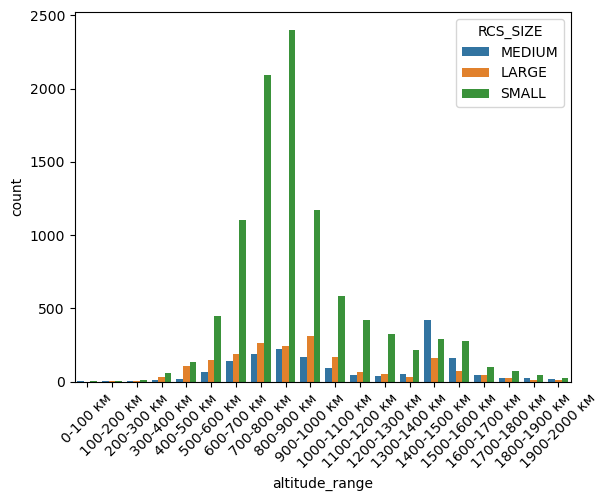

In [34]:
sns.countplot(data=trash_2000, x = 'altitude_range', hue = 'RCS_SIZE')
plt.xticks(rotation=45);

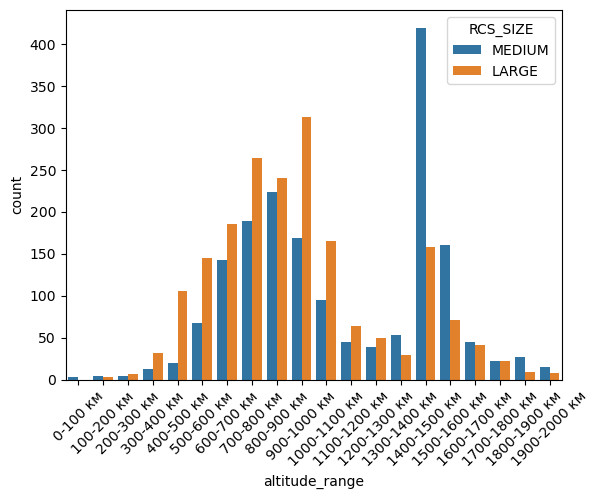

In [35]:
sns.countplot(data=trash_2000[trash_2000['RCS_SIZE'] != 'SMALL'], x = 'altitude_range', hue = 'RCS_SIZE')
plt.xticks(rotation=45);

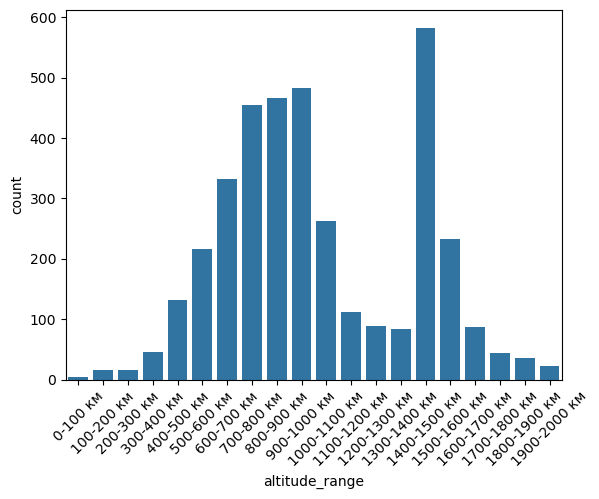

In [36]:
sns.countplot(data=trash_2000[trash_2000['RCS_SIZE'] != 'SMALL'], x = 'altitude_range')
plt.xticks(rotation=45);

In [37]:
#ранжирование наклонения по 10 град
bins = range(0, 160, 10)
labels = [f"{i}-{i+10} град" for i in range(0, 150, 10)]
trash_2000['incl_range'] = pd.cut(trash_2000['INCLINATION'], bins=bins, labels=labels, right=False)
trash_2000

C:\Users\snoga\AppData\Local\Temp\ipykernel_1644\3018962908.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trash_2000['incl_range'] = pd.cut(trash_2000['INCLINATION'], bins=bins, labels=labels, right=False)


,CREATION_DATE,OBJECT_NAME,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,...,RCS_SIZE,LAUNCH_DATE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2,SORTING_DATE,altitude_km,altitude_range,incl_range
11,2025-03-24 06:36:18,VANGUARD 3,2025-03-24 01:21:18.350496,11.605267,0.164438,33.3416,85.8536,162.9213,203.4172,0,...,MEDIUM,1959-09-18,283895836,0 VANGUARD 3,1 20U 59007A 25083.05646239 .00001864 0...,2 20 33.3416 85.8536 1644378 162.9213 203...,1959-09-18 00:00:00.000000,1800.628683,1800-1900 км,30-40 град
12,2025-03-24 02:21:51,EXPLORER 7,2025-03-23 21:10:12.728928,15.172064,0.009406,50.2732,146.0412,125.6794,235.2962,0,...,MEDIUM,1959-10-13,283863299,0 EXPLORER 7,1 00022U 59009A 25082.88209177 .00019738 0...,2 00022 50.2732 146.0412 0094055 125.6794 235...,1959-10-13 00:00:00.000000,452.396640,400-500 км,50-60 град
18,2025-03-24 14:16:18,TIROS 1,2025-03-24 06:08:41.698752,14.777840,0.002216,48.3793,1.3881,131.8633,228.4176,0,...,MEDIUM,1960-04-01,283900485,0 TIROS 1,1 29U 60002B 25083.25603818 .00002805 0...,2 29 48.3793 1.3881 0022156 131.8633 228...,1960-04-01 00:00:00.000000,629.028265,600-700 км,40-50 град
34,2025-03-24 02:21:51,TRANSIT 2A,2025-03-23 19:13:51.005856,14.354395,0.024414,66.6920,111.0213,129.0136,233.2982,0,...,MEDIUM,1960-06-22,283863300,0 TRANSIT 2A,1 00045U 60007A 25082.80128479 .00000846 0...,2 00045 66.6920 111.0213 0244137 129.0136 233...,1960-06-22 00:00:00.000000,956.334783,900-1000 км,60-70 град
35,2025-03-24 02:21:51,SOLRAD 1 (GREB),2025-03-23 21:18:40.059360,14.537470,0.020531,66.6918,14.8456,271.5690,86.1913,0,...,MEDIUM,1960-06-22,283863801,0 SOLRAD 1 (GREB),1 00046U 60007B 25082.88796365 .00003689 0...,2 00046 66.6918 14.8456 0205305 271.5690 86...,1960-06-22 00:00:00.000000,593.024942,500-600 км,60-70 град
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60540,2025-03-24 06:26:21,DMSP 5D-2 F14 DEB,2025-03-23 03:09:43.107552,14.082187,0.011491,99.2078,133.0645,128.9482,232.1995,0,...,SMALL,1997-04-04,283893789,0 DMSP 5D-2 F14 DEB,1 62947U 97012T 25082.13174893 .00101557 0...,2 62947 99.2078 133.0645 0114914 128.9482 232...,1997-04-04 00:00:00.000000,873.790825,800-900 км,90-100 град
60747,2025-03-06 02:35:01,DMSP 5D-2 F14 DEB,2025-03-04 22:36:09.010944,14.224303,0.003528,98.8053,113.6437,327.5677,32.3332,0,...,NaN,NaT,282386296,0 DMSP 5D-2 F14 DEB,1 63154U 97012U 25063.94177096 .00004647 0...,2 63154 98.8053 113.6437 0035285 327.5677 32...,2025-03-04 22:36:09.010944,814.672758,800-900 км,90-100 град
60748,2025-03-06 02:35:01,DMSP 5D-2 F14 DEB,2025-03-05 08:55:44.147136,14.222353,0.003442,98.8080,114.0842,329.2152,30.7007,0,...,NaN,NaT,282386147,0 DMSP 5D-2 F14 DEB,1 63155U 97012V 25064.37203874 .00004701 0...,2 63155 98.8080 114.0842 0034415 329.2152 30...,2025-03-05 08:55:44.147136,820.693314,800-900 км,90-100 град
60849,2025-03-24 11:56:17,DRAGON FREEDOM-2 DEB,2025-03-24 07:53:56.051808,16.293234,0.005346,52.1235,5.4073,83.8132,13.8795,0,...,MEDIUM,2024-09-28,283900136,0 DRAGON FREEDOM-2 DEB,1 63331U 24178B 25083.32912097 .07856431 1...,2 63331 52.1235 5.4073 0053462 83.8132 13...,2024-09-28 00:00:00.000000,160.073279,100-200 км,50-60 град


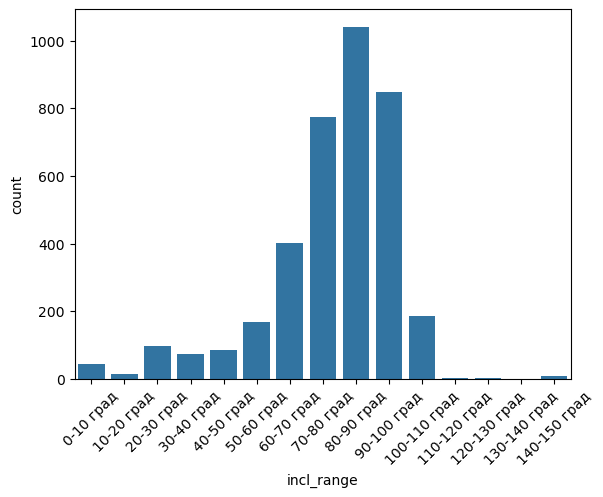

In [38]:
sns.countplot(data=trash_2000[trash_2000['RCS_SIZE'] != 'SMALL'], x = 'incl_range')
plt.xticks(rotation=45);

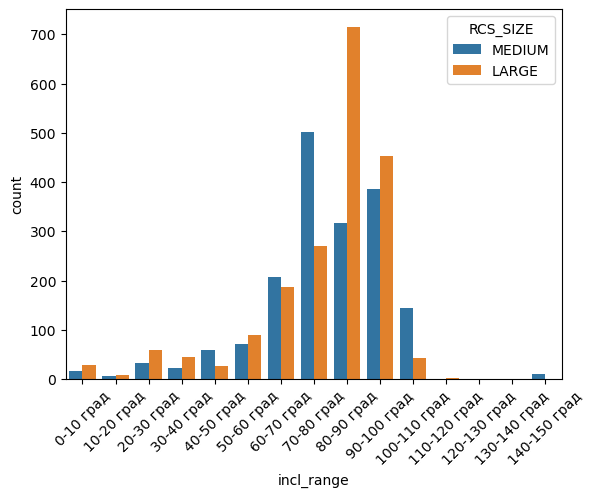

In [39]:
sns.countplot(data=trash_2000[trash_2000['RCS_SIZE'] != 'SMALL'], x = 'incl_range', hue = 'RCS_SIZE')
plt.xticks(rotation=45);

In [40]:
#отдельно исследуем 30-120 градусов

In [41]:
trtr = trash_2000[trash_2000['INCLINATION'] > 29]
trtr = trtr[trtr['INCLINATION'] < 111]

In [42]:
bins = range(30, 120, 10)
labels = [f"{i}-{i+10} град" for i in range(30, 110, 10)]
trtr['incl_range'] = pd.cut(trtr['INCLINATION'], bins=bins, labels=labels, right=False)

(2.0, 15.0)

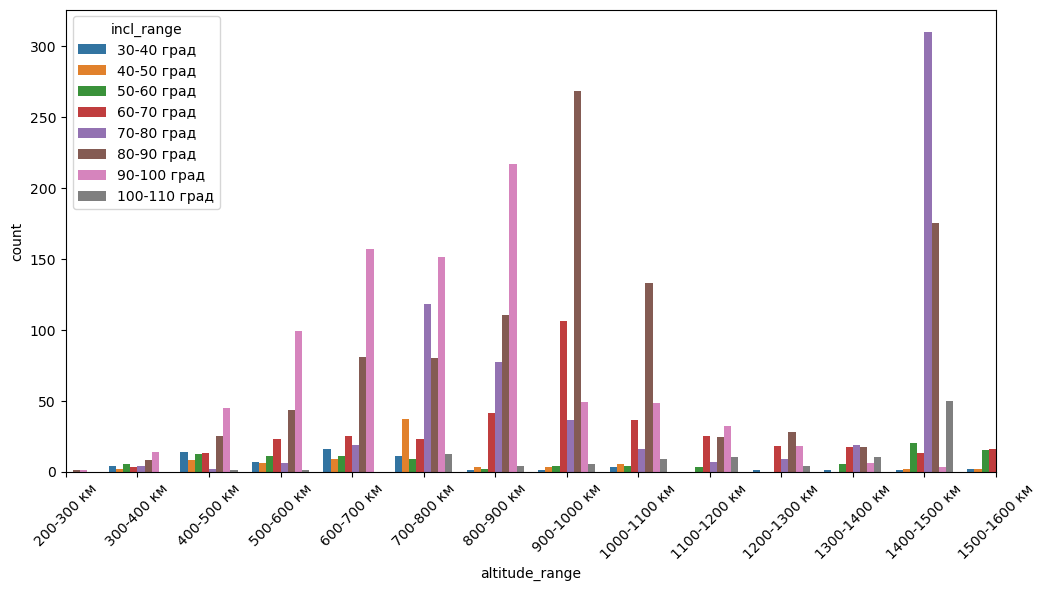

In [43]:
#разделение по наклонениям
plt.figure(figsize=(12,6))
sns.countplot(data=trtr[trtr['RCS_SIZE'] != 'SMALL'], x = 'altitude_range', hue = 'incl_range')
plt.xticks(rotation=45);
plt.xlim('200-300 км', '1500-1600 км')

In [44]:
#отдельно выделяем данные для высот 1400-1500 км и наклонений 70-90 град
trash_1400_1500_70_90 = trash_2000[(trash_2000['altitude_range'] == '1400-1500 км') & 
                                   ((trash_2000['incl_range'] == '70-80 град') | (trash_2000['incl_range'] == '80-90 град'))]

<Axes: xlabel='altitude_km', ylabel='INCLINATION'>

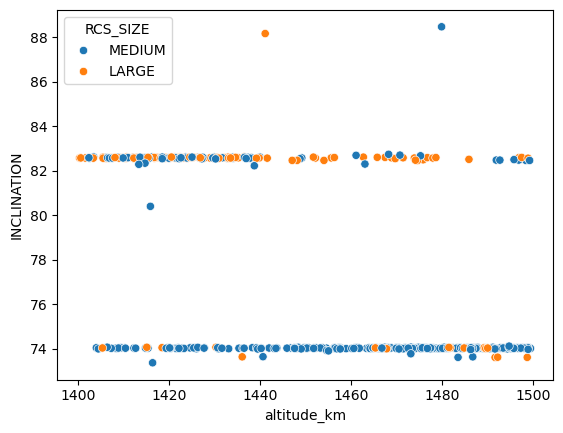

In [45]:
sns.scatterplot(data = trash_1400_1500_70_90[trash_1400_1500_70_90['RCS_SIZE'] != 'SMALL'], 
                x = 'altitude_km', y = 'INCLINATION', hue = 'RCS_SIZE')

In [46]:
#разделение по десяткам для 1400-1500 км
bins = range(0, 1510, 10)
labels = [f"{i}-{i+10} км" for i in range(0, 1500, 10)]
trash_1400_1500_70_90['altitude_range_by10'] = pd.cut(trash_1400_1500_70_90['altitude_km'], bins=bins, labels=labels, right=False)

C:\Users\snoga\AppData\Local\Temp\ipykernel_1644\1982128901.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trash_1400_1500_70_90['altitude_range_by10'] = pd.cut(trash_1400_1500_70_90['altitude_km'], bins=bins, labels=labels, right=False)


(140.0, 149.0)

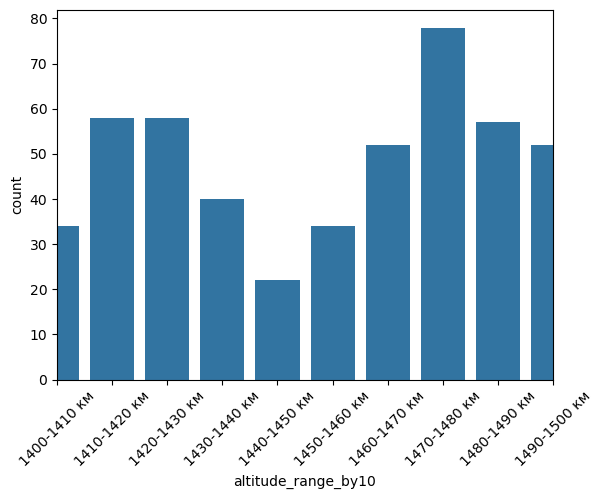

In [47]:
sns.countplot(data=trash_1400_1500_70_90[trash_1400_1500_70_90['RCS_SIZE'] != 'SMALL'], x = 'altitude_range_by10')
plt.xticks(rotation=45);
plt.xlim('1400-1410 км', '1490-1500 км')

(140.0, 149.0)

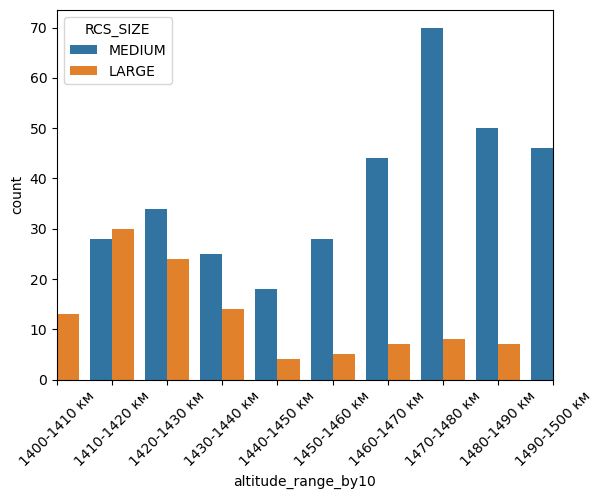

In [48]:
sns.countplot(data=trash_1400_1500_70_90[trash_1400_1500_70_90['RCS_SIZE'] != 'SMALL'], 
              x = 'altitude_range_by10', hue = 'RCS_SIZE')
plt.xticks(rotation=45);
plt.xlim('1400-1410 км', '1490-1500 км')

In [49]:
#отдельно выделяем данные для высот 700-800 км и наклонений 70-100 град
trash_700_800_70_100 = trash_2000[(trash_2000['altitude_range'] == '700-800 км') & 
                                  ((trash_2000['incl_range'] == '70-80 град') | 
                                   (trash_2000['incl_range'] == '80-90 град') | 
                                   (trash_2000['incl_range'] == '90-100 град'))]

<Axes: xlabel='altitude_km', ylabel='INCLINATION'>

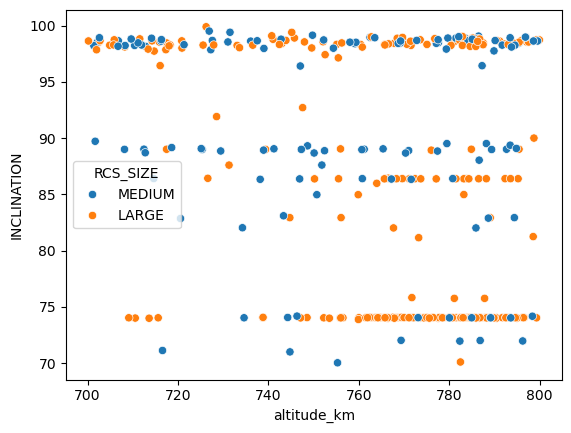

In [50]:
sns.scatterplot(data = trash_700_800_70_100[trash_700_800_70_100['RCS_SIZE'] != 'SMALL'], 
                x = 'altitude_km', y = 'INCLINATION', hue = 'RCS_SIZE')

In [51]:
#разделение по десяткам для 700-800
bins = range(700, 810, 10)
labels = [f"{i}-{i+10} км" for i in range(700, 800, 10)]
trash_700_800_70_100['altitude_range_by10'] = pd.cut(trash_700_800_70_100['altitude_km'], bins=bins, labels=labels, right=False)

C:\Users\snoga\AppData\Local\Temp\ipykernel_1644\3499493993.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trash_700_800_70_100['altitude_range_by10'] = pd.cut(trash_700_800_70_100['altitude_km'], bins=bins, labels=labels, right=False)


(0.0, 9.0)

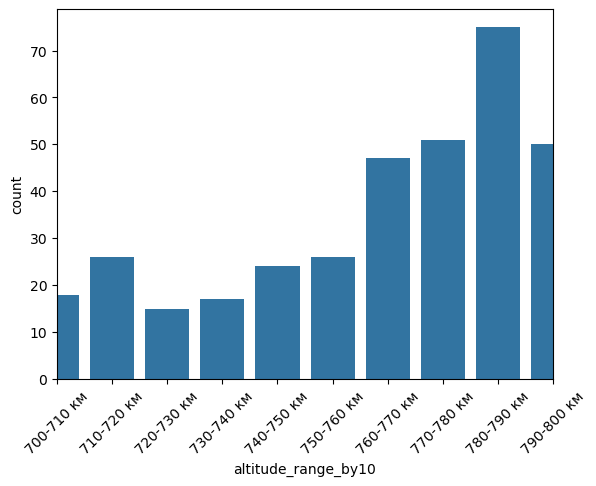

In [52]:
sns.countplot(data=trash_700_800_70_100[trash_700_800_70_100['RCS_SIZE'] != 'SMALL'], x = 'altitude_range_by10')
plt.xticks(rotation=45);
plt.xlim('700-710 км', '790-800 км')

In [53]:
#отдельно выделяем данные для высот 770-800 км и наклонений 70-100 град
trash_770_800_70_100 = trash_2000[(trash_2000['altitude_range'] == '700-800 км') & 
                                  ((trash_2000['incl_range'] == '70-80 град') | 
                                   (trash_2000['incl_range'] == '80-90 град') | 
                                   (trash_2000['incl_range'] == '90-100 град'))]

In [54]:
#разделение по 1 для 770-800
bins = range(770, 801, 1)
labels = [f"{i}-{i+1} км" for i in range(770, 800, 1)]
trash_770_800_70_100['altitude_range_by1'] = pd.cut(trash_770_800_70_100['altitude_km'], bins=bins, labels=labels, right=False)

C:\Users\snoga\AppData\Local\Temp\ipykernel_1644\1549367009.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trash_770_800_70_100['altitude_range_by1'] = pd.cut(trash_770_800_70_100['altitude_km'], bins=bins, labels=labels, right=False)


(0.0, 29.0)

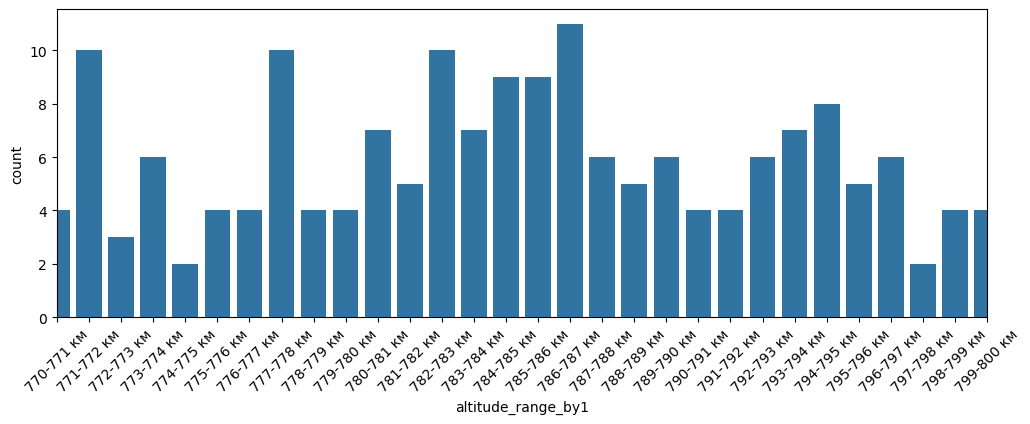

In [55]:
plt.figure(figsize = (12,4))
sns.countplot(data=trash_770_800_70_100[trash_770_800_70_100['RCS_SIZE'] != 'SMALL'], x = 'altitude_range_by1')
plt.xticks(rotation=45);
plt.xlim('770-771 км', '799-800 км')

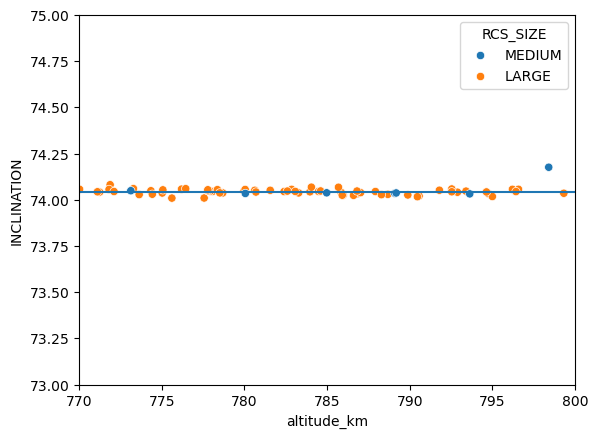

In [56]:
sns.scatterplot(data = trash_700_800_70_100[trash_700_800_70_100['RCS_SIZE'] != 'SMALL'], 
                x = 'altitude_km', y = 'INCLINATION', hue = 'RCS_SIZE')
plt.xlim(770,800)
plt.ylim(73,75)
grad = 74.04
plt.plot([770, 800], [grad,grad])

In [57]:
#итого для высот 770-800 км и наклонения 74 град
trash_final_800 = trash_2000[(trash_2000['altitude_km'] > 770) & (trash_2000['altitude_km'] < 800) & 
                             (trash_2000['INCLINATION'] < 74.25) & (trash_2000['INCLINATION'] > 74)]

In [58]:
len(trash_final_800[trash_final_800['RCS_SIZE'] != 'SMALL'])

71

In [59]:
len(trash_final_800[trash_final_800['RCS_SIZE'] == 'MEDIUM'])

7

In [60]:
len(trash_final_800[trash_final_800['RCS_SIZE'] == 'LARGE'])

64

In [61]:
#Какие объекты находятся по выбранным параметрам 770-800 км (Стрела-2М)
trash_final_800[trash_final_800['RCS_SIZE'] != 'SMALL']['OBJECT_NAME'].unique()

array(['COSMOS 372', 'COSMOS 407', 'COSMOS 468', 'COSMOS 494',
       'COSMOS 540', 'COSMOS 783', 'COSMOS 836', 'COSMOS 841',
       'COSMOS 858', 'COSMOS 923', 'COSMOS 968', 'COSMOS 990',
       'COSMOS 1048', 'COSMOS 1110', 'COSMOS 1125', 'COSMOS 1140',
       'COSMOS 1190', 'COSMOS 1269', 'COSMOS 1302', 'COSMOS 1331',
       'COSMOS 1354', 'COSMOS 1452', 'COSMOS 1486', 'COSMOS 1503',
       'COSMOS 1624', 'COSMOS 1680', 'COSMOS 1741', 'COSMOS 1763',
       'COSMOS 1814', 'COSMOS 1850', 'COSMOS 1954', 'COSMOS 1992',
       'COSMOS 2112', 'COSMOS 2150', 'COSMOS 2208', 'COSMOS 2251',
       'COSMOS 2298', 'SL-8 R/B', 'COSMOS 2251 DEB'], dtype=object)

In [62]:
#Какие объекты находятся по выбранным параметрам 1400-1500 км (Стрела-1М, Стрела-3)
trash_1400_1500_70_90[trash_1400_1500_70_90['RCS_SIZE'] != 'SMALL']['OBJECT_NAME'].unique()

array(['OPS 2644', 'COSMOS 336', 'COSMOS 337', 'COSMOS 338', 'COSMOS 339',
       'COSMOS 340', 'COSMOS 341', 'COSMOS 342', 'COSMOS 343', 'ISIS 2',
       'COSMOS 411', 'COSMOS 414', 'COSMOS 415', 'COSMOS 417',
       'COSMOS 418', 'COSMOS 447', 'COSMOS 448', 'COSMOS 504',
       'COSMOS 507', 'COSMOS 508', 'COSMOS 509', 'COSMOS 528',
       'COSMOS 529', 'COSMOS 530', 'COSMOS 531', 'COSMOS 533',
       'COSMOS 535', 'COSMOS 564', 'COSMOS 565', 'COSMOS 566',
       'COSMOS 567', 'COSMOS 568', 'COSMOS 570', 'COSMOS 571',
       'COSMOS 588', 'COSMOS 589', 'COSMOS 590', 'COSMOS 591',
       'COSMOS 593', 'COSMOS 594', 'COSMOS 595', 'COSMOS 619',
       'COSMOS 620', 'COSMOS 621', 'COSMOS 622', 'COSMOS 623',
       'COSMOS 641', 'COSMOS 642', 'COSMOS 643', 'COSMOS 644',
       'COSMOS 645', 'COSMOS 646', 'COSMOS 647', 'COSMOS 648',
       'COSMOS 650', 'COSMOS 675', 'COSMOS 677', 'COSMOS 680',
       'COSMOS 681', 'COSMOS 682', 'COSMOS 683', 'COSMOS 684',
       'COSMOS 711', 'COSMOS 712'

In [63]:
#отдельно выделяем данные для высот 800-900 км и наклонений 70-100 град
trash_800_900_70_100 = trash_2000[(trash_2000['altitude_range'] == '800-900 км') & 
                                  ((trash_2000['incl_range'] == '70-80 град') | 
                                   (trash_2000['incl_range'] == '80-90 град') |
                                   (trash_2000['incl_range'] == '90-100 град'))]

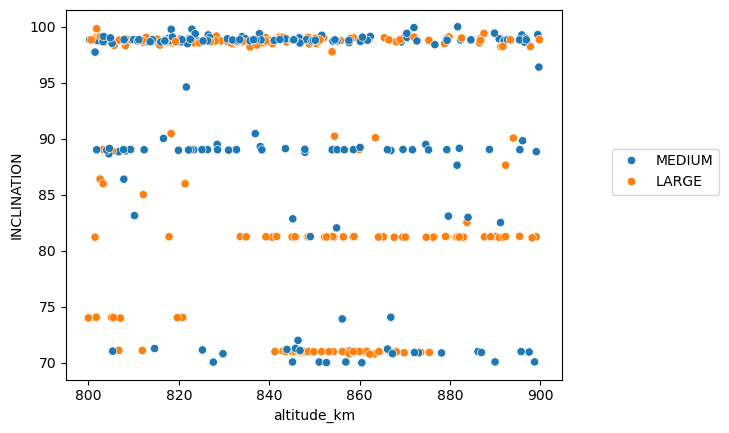

In [64]:
sns.scatterplot(data = trash_800_900_70_100[trash_800_900_70_100['RCS_SIZE'] != 'SMALL'],
                x = 'altitude_km', y = 'INCLINATION', hue = 'RCS_SIZE')
plt.legend(loc = (1.1,0.5))

In [65]:
#итого для высот 800-900 км и наклонения около 98 град
trash_final_900_98 = trash_2000[(trash_2000['altitude_km'] >= 800) & (trash_2000['altitude_km'] <= 900) & 
                                (trash_2000['INCLINATION'] < 100) & (trash_2000['INCLINATION'] > 96)]

#Какие объекты находятся по выбранным параметрам
trash_final_900_98[trash_final_900_98['RCS_SIZE'] != 'SMALL']['OBJECT_NAME'].unique()

array(['OPS 3367 A', 'OPS 3367 B', 'OPS 4467 A', 'OPS 4467 B', 'TIROS 9',
       'OPS 7202 (DMSP 4A F3)', 'OPS 7869 (DMSP 4B F1)',
       'OPS 4078 (DMSP 4B F2)', 'OPS 0203 (DMSP 5A F2)',
       'OPS 4311 (DMSP 5B F1)', 'OPS 5058 (DMSP 5B F2)',
       'OPS 8579 (DMSP 5B F5)', 'OPS 6226', 'OPS 5721', 'OPS 5644',
       'OSCAR 8', 'TIROS N', 'OPS 5390', 'NOAA 7',
       'OPS 9845 (DMSP 5D-2 F6)', 'NOAA 9', 'DMSP 5D-2 F8 (USA 26)',
       'DMSP 5D-2 F9 (USA 29)', 'FENGYUN 1A', 'NOAA 11', 'COBE',
       'OSCAR 15 (UOSAT 4)', 'FENGYUN 1B', 'DMSP 5D-2 F10 (USA 68)',
       'NOAA 12', 'IRS 1B', 'DMSP 5D-2 F11 (USA 73)', 'NOAA 13', 'SPOT 3',
       'STELLA', 'EYESAT A', 'ITAMSAT', 'HEALTHSAT 1', 'KITSAT B',
       'POSAT 1', 'DMSP 5D-2 F12 (USA 106)', 'IRS P2', 'NOAA 14',
       'DMSP 5D-2 F13 (USA 109)', 'IRS 1C', 'SKIPPER', 'IRS B3', 'ADEOS',
       'DMSP 5D-2 F14 (USA 131)', 'IRS 1D', 'NOAA 15', 'RESURS O1-N4',
       'FASAT B', 'TMSAT', 'TECHSAT 1B', 'WESTPAC', 'SAFIR 2', 'ARGOS',
       '

In [66]:
#итого для высот 800-900 км и наклонения около 89 град
trash_final_900_89 = trash_2000[(trash_2000['altitude_km'] >= 800) & (trash_2000['altitude_km'] <= 900) & 
                                (trash_2000['INCLINATION'] < 91) & (trash_2000['INCLINATION'] > 86)]

#Какие объекты находятся по выбранным параметрам
trash_final_900_89[trash_final_900_89['RCS_SIZE'] != 'SMALL']['OBJECT_NAME'].unique()

array(['OPS 4412 (TRANSIT 9)', 'DODECAPOLE 2', 'OPS 0082 (TRANSIT 13)',
       'RADCAL', 'REX 2', 'IRIDIUM 7', 'COROT', 'SCOUT X-4 R/B',
       'SCOUT A R/B', 'OV1-21 R/B', 'SCOUT G-1 R/B', 'CZ-6A R/B',
       'OV1-20/OV1-21 DEB', 'TRANSIT 10 DEB', 'IRIDIUM 33 DEB',
       'BREEZE-M DEB', 'CZ-6A DEB'], dtype=object)

(80.0, 82.0)

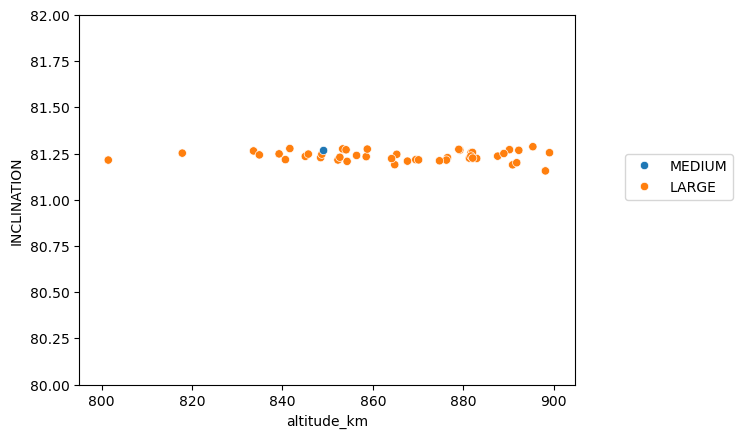

In [67]:
sns.scatterplot(data = trash_800_900_70_100[trash_800_900_70_100['RCS_SIZE'] != 'SMALL'],
                x = 'altitude_km', y = 'INCLINATION', hue = 'RCS_SIZE')
plt.legend(loc = (1.1,0.5))
plt.ylim(80,82)

In [68]:
#итого для высот 800-900 км и наклонения около 81 град
trash_final_900_81 = trash_2000[(trash_2000['altitude_km'] >= 800) & (trash_2000['altitude_km'] <= 900) & 
                                (trash_2000['INCLINATION'] < 82) & (trash_2000['INCLINATION'] > 80)]

#Какие объекты находятся по выбранным параметрам (Метеор)
trash_final_900_81[trash_final_900_81['RCS_SIZE'] != 'SMALL']['OBJECT_NAME'].unique()

array(['METEOR 1-5', 'METEOR 1-10', 'METEOR 1-11', 'METEOR 1-12',
       'METEOR 1-13', 'METEOR 1-15', 'METEOR 1-16', 'METEOR 1-17',
       'METEOR 1-19', 'METEOR 1-20', 'METEOR 1-21', 'METEOR 2-1',
       'METEOR 1-23', 'METEOR 1-24', 'METEOR 1-25', 'METEOR 1-26',
       'METEOR 2-2', 'METEOR 1-27', 'METEOR 2-3', 'COSMOS 1066',
       'METEOR 2-4', 'METEOR 2-5', 'METEOR 2-6', 'METEOR 2-7',
       'INTERCOSMOS 22', 'METEOR 2-9', 'SL-3 R/B', 'METEOR 1-10 DEB'],
      dtype=object)

In [69]:
#отдельно выделяем данные для высот 600-700 км и наклонений 70-100 град
trash_600_700_60_100 = trash_2000[(trash_2000['altitude_range'] == '600-700 км') & 
                                  (trash_2000['INCLINATION'] > 60) & (trash_2000['INCLINATION'] < 100)]

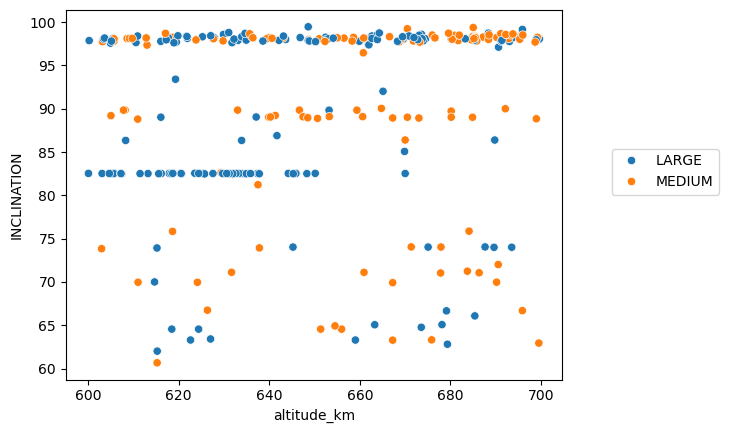

In [70]:
sns.scatterplot(data = trash_600_700_60_100[trash_600_700_60_100['RCS_SIZE'] != 'SMALL'], 
                x = 'altitude_km', y = 'INCLINATION', hue = 'RCS_SIZE')
plt.legend(loc = (1.1,0.5))
#plt.ylim(82,85)

In [71]:
#итого для высот 600-700 км и наклонения около 97-99 град
trash_final_700_98 = trash_2000[(trash_2000['altitude_km'] >= 600) & (trash_2000['altitude_km'] <= 700) & 
                                (trash_2000['INCLINATION'] < 99) & (trash_2000['INCLINATION'] > 97)]

#Какие объекты находятся по выбранным параметрам
trash_final_700_98[trash_final_700_98['RCS_SIZE'] != 'SMALL']['OBJECT_NAME'].unique()

array(['OPS 8068', 'ESSA 1 (OT-3)', 'OPS 0340', 'OPS 6026 (DMSP 4A F1)',
       'OPS 8180 (STP RADSAT)', 'OSCAR 11 (UoSAT 2)', 'SPOT 2',
       'RESURS O1', 'UPM/LBSAT', 'OKEAN O', 'HELIOS 1B', 'TERRA',
       'KOMPSAT', 'ACRIMSAT', 'NADEZHDA 6', 'TZINGHUA 1', 'SNAP 1',
       'EO 1', 'SAC C', 'AQUA', 'ALSAT 1', 'MOZHAYETS', 'MOZHAYETS 4',
       'RUBIN 4/SL-8', 'UK-DMC', 'BILSAT 1', 'LARETS', 'KAISTSAT 4',
       'DEMETER', 'SHIYAN 2 (SY-2)', 'NANOSAT(1)', 'PARASOL',
       'CARTOSAT-1', 'BEIJING 1 (TSINGHUA)', 'TOPSAT', 'SSETI-EXPRESS',
       'MOZ.5/SAFIR/RUBIN 5/SL-8', 'ALOS', 'YAOGAN 1', 'CLOUDSAT',
       'CALIPSO', 'KOMPSAT 2', 'HINODE (SOLAR B)', 'METOP-A',
       'LAPAN-TUBSAT', 'EGYPTSAT 1', 'SAUDISAT 3', 'YAOGAN 2', 'SKYMED 1',
       'YAOGAN 3', 'SKYMED 2', 'CARTOSAT 2A', 'CANX-6', 'RUBIN 8/PSLV',
       'HJ-1A', 'HJ-1B', 'SHIJIAN 6 03B (SJ-6 03B)', 'YAOGAN 4',
       'GOSAT (IBUKI)', 'SPRITE-SAT (RISING)', 'KAGAYAKI',
       'SOHLA-1 (MAIDO-1)', 'SDS-1', 'STARS (KUKAI)', '

In [72]:
#итого для высот 600-700 км и наклонения около 82 град
trash_final_700_82 = trash_2000[(trash_2000['altitude_km'] >= 600) & (trash_2000['altitude_km'] <= 700) & 
                                (trash_2000['INCLINATION'] < 83) & (trash_2000['INCLINATION'] > 82)]

#Какие объекты находятся по выбранным параметрам (рб Циклона-3)
trash_final_700_82[trash_final_700_82['RCS_SIZE'] != 'SMALL']['OBJECT_NAME'].unique()

array(['MAGION 2', 'OKEAN 4', 'SL-14 R/B'], dtype=object)

In [73]:
#сколько SL-14
trash_final_700_82[trash_final_700_82['RCS_SIZE'] != 'SMALL']

,CREATION_DATE,OBJECT_NAME,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,...,RCS_SIZE,LAUNCH_DATE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2,SORTING_DATE,altitude_km,altitude_range,incl_range
18686,2025-03-24 06:26:21,MAGION 2,2025-03-24 00:05:08.380608,12.621357,0.117515,82.6034,306.9208,285.9745,61.5177,0,...,MEDIUM,1989-09-28,283894457,0 MAGION 2,1 20281U 89080B 25083.00356922 .00001868 0...,2 20281 82.6034 306.9208 1175153 285.9745 61...,1989-09-28,629.354613,600-700 км,80-90 град
21647,2025-03-24 06:36:18,OKEAN 4,2025-03-24 03:19:06.763008,14.948763,0.001695,82.5363,324.2208,352.8430,7.2546,0,...,LARGE,1994-10-11,283895252,0 OKEAN 4,1 23317U 94066A 25083.13827272 .00005791 0...,2 23317 82.5363 324.2208 0016952 352.8430 7...,1994-10-11,600.078048,600-700 км,80-90 град
9640,2025-03-24 02:21:51,SL-14 R/B,2025-03-23 22:08:51.604800,14.894873,0.001526,82.4850,0.6210,299.5059,60.4637,0,...,LARGE,1978-06-28,283865502,0 SL-14 R/B,1 10974U 78067B 25082.92281950 .00002059 0...,2 10974 82.4850 0.6210 0015258 299.5059 60...,1978-06-28,607.426034,600-700 км,80-90 град
11397,2025-03-24 06:26:21,SL-14 R/B,2025-03-24 04:58:11.253216,14.866847,0.001557,82.4912,172.1452,241.8033,118.1611,0,...,LARGE,1981-08-24,283894256,0 SL-14 R/B,1 12786U 81082B 25083.20707469 .00001604 0...,2 12786 82.4912 172.1452 0015571 241.8033 118...,1981-08-24,629.892787,600-700 км,80-90 град
11592,2025-03-24 06:36:18,SL-14 R/B,2025-03-24 00:45:06.173280,14.867726,0.001720,82.5208,290.6089,184.3164,175.7907,0,...,LARGE,1981-12-03,283896002,0 SL-14 R/B,1 12988U 81117B 25083.03132145 .00001508 0...,2 12988 82.5208 290.6089 0017197 184.3164 175...,1981-12-03,632.128687,600-700 км,80-90 град
11872,2025-03-24 02:21:51,SL-14 R/B,2025-03-23 20:03:16.167456,14.866918,0.001940,82.5132,352.0022,102.9797,257.3587,0,...,LARGE,1982-06-10,283866824,0 SL-14 R/B,1 13272U 82059B 25082.83560379 .00001760 0...,2 13272 82.5132 352.0022 0019399 102.9797 257...,1982-06-10,648.301642,600-700 км,80-90 град
12149,2025-03-24 14:26:18,SL-14 R/B,2025-03-24 11:17:35.461248,14.861868,0.002131,82.5647,108.9053,26.9566,87.4817,0,...,LARGE,1982-09-16,283901286,0 SL-14 R/B,1 13553U 82092B 25083.47054932 .00001408 0...,2 13553 82.5647 108.9053 0021305 26.9566 87...,1982-09-16,645.948399,600-700 км,80-90 град
12607,2025-03-24 06:46:18,SL-14 R/B,2025-03-24 01:30:00.350784,14.857240,0.001854,82.5088,202.1447,111.8497,248.4693,0,...,LARGE,1983-04-23,283896150,0 SL-14 R/B,1 14033U 83037B 25083.06250406 .00001974 0...,2 14033 82.5088 202.1447 0018543 111.8497 248...,1983-04-23,605.177158,600-700 км,80-90 град
12715,2025-03-24 02:21:51,SL-14 R/B,2025-03-23 20:47:53.319840,14.852196,0.002029,82.5172,131.0999,341.8302,18.2187,0,...,LARGE,1983-06-23,283866452,0 SL-14 R/B,1 14148U 83061B 25082.86658935 .00001336 0...,2 14148 82.5172 131.0999 0020291 341.8302 18...,1983-06-23,634.040980,600-700 км,80-90 град
12937,2025-03-24 02:21:51,SL-14 R/B,2025-03-23 19:41:32.235072,14.857546,0.001845,82.5362,111.7170,216.1246,143.8725,0,...,LARGE,1983-09-28,283866478,0 SL-14 R/B,1 14373U 83099B 25082.82051198 .00001415 0...,2 14373 82.5362 111.7170 0018452 216.1246 143...,1983-09-28,625.080568,600-700 км,80-90 град


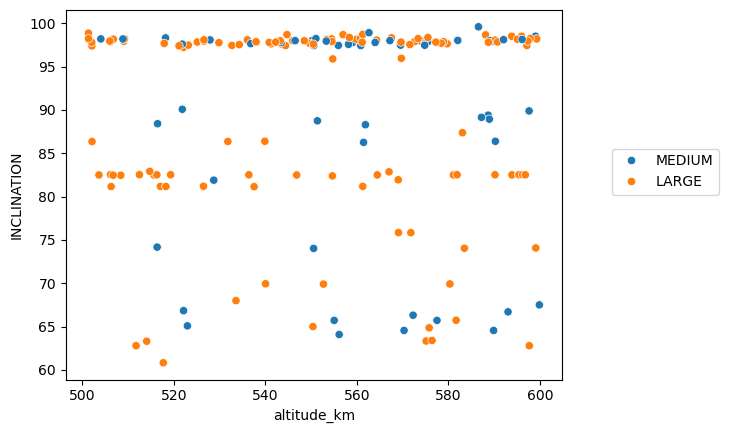

In [74]:
#отдельно выделяем данные для высот 500-600 км и наклонений 70-100 град
trash_500_600_60_100 = trash_2000[(trash_2000['altitude_range'] == '500-600 км') & 
                                  (trash_2000['INCLINATION'] > 60) & (trash_2000['INCLINATION'] < 100)]

sns.scatterplot(data = trash_500_600_60_100[trash_500_600_60_100['RCS_SIZE'] != 'SMALL'], 
                x = 'altitude_km', y = 'INCLINATION', hue = 'RCS_SIZE')
plt.legend(loc = (1.1,0.5))
#plt.ylim(97,100)

In [75]:
#итого для высот 500-600 км и наклонения около 98 град
trash_final_600_98 = trash_2000[(trash_2000['altitude_km'] >= 500) & (trash_2000['altitude_km'] <= 600) & 
                                (trash_2000['INCLINATION'] < 100) & (trash_2000['INCLINATION'] > 97)]

#Какие объекты находятся по выбранным параметрам
trash_final_600_98[trash_final_600_98['RCS_SIZE'] != 'SMALL']['OBJECT_NAME'].unique()

array(['FTV 3502', 'LANDSAT 5', 'SPOT 1', 'CERISE', 'IKONOS 2',
       'CLEMENTINE', 'PROBA 1', 'NIGERIASAT 1', 'TANSUO 1', 'NAXING 1',
       'SHIJIAN 6 01A (SJ-6 01A)', 'SHIJIAN 6 01B (SJ-6 01B)', 'JB-3 C',
       'HELIOS 2A', 'HAMSAT', 'SJ-7', 'OICETS', 'INDEX',
       'SHIJIAN 6 02A (SJ-6 02A)', 'SHIJIAN 6 02B (SJ-6 02B)',
       'TERRA SAR X', 'CUTE-1.7+APD II', 'IMS-1', 'RAPIDEYE 2',
       'RAPIDEYE 5', 'RAPIDEYE 1', 'RAPIDEYE 3', 'RAPIDEYE 4',
       'SHIJIAN 6 03A (SJ-6 03A)', 'SKYMED 3', 'DELTA 1 R/B', 'SL-3 R/B',
       'ARIANE 40 R/B', 'SL-18 R/B', 'CZ-4B R/B', 'H-2A R/B', 'SL-19 R/B',
       'PSLV R/B', 'PEGASUS R/B', 'SL-24 R/B', 'CZ-4C R/B', 'CZ-2C R/B',
       'AVUM R/B', 'ELECTRON KICK STAGE R/B', 'CZ-2D R/B', 'CZ-6A R/B',
       'THORAD AGENA D DEB', 'CZ-4 DEB', 'PSLV DEB', 'DELTA 2 DEB (DPAF)',
       'SL-24 DEB', 'YAOGAN 1 DEB', 'CZ-2C DEB', 'SL-24 PLAT',
       'CZ-4C DEB', 'CZ-4B DEB', 'RESURS O1 DEB', 'STRIX-BETA DEB',
       'CZ-6A DEB', 'DMSP 5D-2 F14 DEB'], dt

In [76]:
#итого для высот 500-600 км и наклонения около 83 град
trash_final_600_83 = trash_2000[(trash_2000['altitude_km'] >= 500) & (trash_2000['altitude_km'] <= 600) & 
                                (trash_2000['INCLINATION'] < 85) & (trash_2000['INCLINATION'] > 80)]

#Какие объекты находятся по выбранным параметрам
trash_final_600_83[trash_final_600_83['RCS_SIZE'] != 'SMALL']['OBJECT_NAME'].unique()

array(['COSMOS 1263', 'COSMOS 1328', 'COSMOS 1536', 'COSMOS 1758',
       'COSMOS 1782', 'COSMOS 1862', 'COSMOS 1933', 'COSMOS 1953',
       'OKEAN 1', 'COSMOS 1975', 'COSMOS 2058', 'OKEAN 2', 'OKEAN 3',
       'COSMOS 2151', 'COSMOS 2221', 'COSMOS 2228', 'COSMOS 2242',
       'STEP 2', 'SICH 1', 'SL-14 R/B', 'SL-3 R/B', 'SL-8 R/B',
       'PEGASUS DEB'], dtype=object)

In [78]:
#исследуем разгонник sl3
df_sl = pd.read_csv("../Data/all_objects.csv")
sl3 = df_sl[df_sl['OBJECT_NAME']== 'SL-3 R/B']
sl3['altitude_km'] = sl3.apply(lambda row: calculate_altitude(row['TLE_LINE1'], row['TLE_LINE2']), axis=1)

sl3=sl3[sl3['DECAY_DATE'].isna()]
sl3[(sl3['altitude_km'] <= 600) &(sl3['altitude_km'] >=200)]['altitude_km']

C:\Users\snoga\AppData\Local\Temp\ipykernel_1644\908896207.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sl3['altitude_km'] = sl3.apply(lambda row: calculate_altitude(row['TLE_LINE1'], row['TLE_LINE2']), axis=1)


4433     474.339668
8823     454.946291
11078    478.519949
11199    515.023459
11511    509.089936
11672    515.134296
11723    521.853231
11755    550.996044
12000    535.931731
12360    519.171213
12408    472.015901
12773    493.428257
17488    528.141633
Name: altitude_km, dtype: float64

In [80]:
sl3

,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,...,COUNTRY_CODE,LAUNCH_DATE,SITE,DECAY_DATE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2,altitude_km
813,3.0,GENERATED VIA SPACE-TRACK.ORG API,2025-03-24T14:26:18,18 SPCS,SL-3 R/B,1964-053B,EARTH,TEME,UTC,SGP4,...,CIS,1964-08-28,TTMTR,NaN,4679164,283901810,0 SL-3 R/B,1 877U 64053B 25083.53656200 .00001160 0...,2 877 65.0764 277.4333 0048295 70.7008 289...,682.820024
3764,3.0,GENERATED VIA SPACE-TRACK.ORG API,2025-03-24T06:26:21,18 SPCS,SL-3 R/B,1970-047B,EARTH,TEME,UTC,SGP4,...,CIS,1970-06-23,PKMTR,NaN,4678837,283893775,0 SL-3 R/B,1 4420U 70047B 25083.01856456 .00000475 0...,2 4420 81.2268 77.6718 0088244 108.6898 252...,915.977543
4433,3.0,GENERATED VIA SPACE-TRACK.ORG API,2025-03-24T02:21:51,18 SPCS,SL-3 R/B,1971-028B,EARTH,TEME,UTC,SGP4,...,CIS,1971-04-07,PKMTR,NaN,4678815,283864336,0 SL-3 R/B,1 05118U 71028B 25082.87750962 .00029683 0...,2 05118 81.2428 117.8148 0028894 85.7597 274...,474.339668
5019,3.0,GENERATED VIA SPACE-TRACK.ORG API,2025-03-24T14:26:18,18 SPCS,SL-3 R/B,1971-120B,EARTH,TEME,UTC,SGP4,...,CIS,1971-12-29,PKMTR,NaN,4679153,283901761,0 SL-3 R/B,1 5732U 71120B 25083.48669543 .00000093 0...,2 5732 81.2484 261.9732 0050751 346.5521 13...,841.949170
5194,3.0,GENERATED VIA SPACE-TRACK.ORG API,2025-03-24T02:21:51,18 SPCS,SL-3 R/B,1972-022B,EARTH,TEME,UTC,SGP4,...,CIS,1972-03-30,PKMTR,NaN,4678815,283864412,0 SL-3 R/B,1 05918U 72022B 25082.79145995 .00000360 0...,2 05918 81.2334 101.4907 0057495 275.3618 84...,858.062063
5348,3.0,GENERATED VIA SPACE-TRACK.ORG API,2025-03-24T02:21:51,18 SPCS,SL-3 R/B,1972-049B,EARTH,TEME,UTC,SGP4,...,CIS,1972-06-30,PKMTR,NaN,4678815,283864924,0 SL-3 R/B,1 06080U 72049B 25082.89518204 .00000178 0...,2 06080 81.2397 145.1349 0047971 240.3515 119...,920.350464
5520,3.0,GENERATED VIA SPACE-TRACK.ORG API,2025-03-24T02:21:51,18 SPCS,SL-3 R/B,1972-085B,EARTH,TEME,UTC,SGP4,...,CIS,1972-10-26,PKMTR,NaN,4678815,283864944,0 SL-3 R/B,1 06257U 72085B 25082.67220664 .00000155 0...,2 06257 81.2564 298.9981 0058291 66.4335 294...,891.224906
5652,3.0,GENERATED VIA SPACE-TRACK.ORG API,2025-03-24T02:21:51,18 SPCS,SL-3 R/B,1973-015B,EARTH,TEME,UTC,SGP4,...,CIS,1973-03-20,PKMTR,NaN,4678815,283864958,0 SL-3 R/B,1 06393U 73015B 25082.97817576 .00000244 0...,2 06393 81.2516 93.4651 0057761 226.0145 133...,925.362150
5823,3.0,GENERATED VIA SPACE-TRACK.ORG API,2025-03-24T02:21:51,18 SPCS,SL-3 R/B,1973-034B,EARTH,TEME,UTC,SGP4,...,CIS,1973-05-29,PKMTR,NaN,4678815,283864459,0 SL-3 R/B,1 06660U 73034B 25082.87676710 .00000158 0...,2 06660 81.2300 139.1651 0047565 40.3391 320...,922.546056
6349,3.0,GENERATED VIA SPACE-TRACK.ORG API,2025-03-24T14:26:18,18 SPCS,SL-3 R/B,1974-011B,EARTH,TEME,UTC,SGP4,...,CIS,1974-03-05,PKMTR,NaN,4679180,283901961,0 SL-3 R/B,1 7210U 74011B 25083.41968183 .00000325 0...,2 7210 81.2371 149.0029 0079675 227.5287 131...,889.178212


In [82]:
sl3[sl3['OBJECT_ID']=='1983-010B']

,CCSDS_OMM_VERS,COMMENT,CREATION_DATE,ORIGINATOR,OBJECT_NAME,OBJECT_ID,CENTER_NAME,REF_FRAME,TIME_SYSTEM,MEAN_ELEMENT_THEORY,...,COUNTRY_CODE,LAUNCH_DATE,SITE,DECAY_DATE,FILE,GP_ID,TLE_LINE0,TLE_LINE1,TLE_LINE2,altitude_km
12408,3.0,GENERATED VIA SPACE-TRACK.ORG API,2025-03-24T02:21:51,18 SPCS,SL-3 R/B,1983-010B,EARTH,TEME,UTC,SGP4,...,CIS,1983-02-16,PKMTR,NaN,4678815,283866411,0 SL-3 R/B,1 13819U 83010B 25082.90081076 .00022813 0...,2 13819 81.1048 68.7373 0020111 179.0149 181...,472.015901
